In [1]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import math
import time
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.dates as mdates
from tqdm import tqdm
from datetime import datetime
from typing import Any, Tuple

from sklearn.preprocessing import StandardScaler
from scipy.cluster.hierarchy import dendrogram, linkage
from scipy.stats import norm, t, ttest_1samp

from pycgapi import CoinGeckoAPI
from alpaca.trading.client import TradingClient
from alpaca.trading.requests import GetAssetsRequest, MarketOrderRequest
from alpaca.trading.enums import AssetClass, OrderSide, TimeInForce

from pypfopt.risk_models import CovarianceShrinkage
from pypfopt.hierarchical_portfolio import HRPOpt
from pypfopt.expected_returns import returns_from_prices

import bt
import ffn

from alpaca.data.requests import CryptoBarsRequest
from alpaca.data.timeframe import TimeFrame
from alpaca.data.historical import CryptoHistoricalDataClient

# 1. Read data

In [2]:
coingecko_key = 'CG-N835eZkqmYYmNUkRGAfYyjmT'
alpaca_key = 'PKR7UF6ZEVT9IE143VMD'
alpaca_secret = '25ce5rjLcsa6UfavZVZkf8WfQ2x4f2EOgq5hccdQ'

In [3]:
# Initialize the CoinGecko API client
cg = CoinGeckoAPI(coingecko_key)

# Check API server status
try:
    status = cg.status_check()
    print("CoinGecko API Server Status:", status)
except Exception as e:
    print("Error checking CoinGecko API status:", e)

CoinGecko API Server Status: {'gecko_says': '(V3) To the Moon!'}


In [4]:
# Initialize the Alpaca trading client
paper = True
trading_client = TradingClient(alpaca_key, alpaca_secret, paper=paper)

# Output initialization status
trading_mode = "Paper Trading" if paper else "Live Trading"
print(f"Alpaca Trading Client Initialized: {trading_mode}")

Alpaca Trading Client Initialized: Paper Trading


In [5]:
# Get tradable crypto assets on Alpaca
search_params = GetAssetsRequest(asset_class=AssetClass.CRYPTO)
assets = trading_client.get_all_assets(search_params)
tradable_assets = pd.DataFrame([
    {'symbol': asset.symbol, 'tradable': asset.tradable}
    for asset in assets
]).set_index('symbol').sort_index()
print('Tradable Currency Pairs on Alpaca:\n')
print(tradable_assets.head())

Tradable Currency Pairs on Alpaca:

           tradable
symbol             
AAVE/USD       True
AAVE/USDC      True
AAVE/USDT      True
AVAX/USD       True
AVAX/USDC      True


In [9]:
# Store CoinGecko search results for tickers
search_results_dict = {}
for symbol in tqdm(tradable_assets.index):
    quote_currency, base_currency = symbol.split('/')
    if base_currency == 'USD' and tradable_assets.loc[symbol, 'tradable']:
        print(quote_currency)
        search_results = cg.search_coingecko(query=quote_currency)['coins']
        search_results_dict[symbol] = search_results

# Display search results
print(f"\n\nFound CoinGecko IDs for {len(search_results_dict)} assets.")

 18%|███████▋                                   | 10/56 [00:00<00:00, 82.97it/s]

AAVE
AVAX
BAT
BCH
BTC
CRV
DOGE
DOT


 61%|█████████████████████████▍                | 34/56 [00:00<00:00, 102.88it/s]

ETH
GRT
LINK
LTC
MKR
SHIB
SUSHI
UNI


 82%|███████████████████████████████████▎       | 46/56 [00:00<00:00, 52.47it/s]

USDC
USDT
XTZ
YFI


100%|███████████████████████████████████████████| 56/56 [00:01<00:00, 38.43it/s]



Found CoinGecko IDs for 20 assets.


In [10]:
# Dictionary for storing found CoinGecko coin IDs
found_coin_ids = {
    key: value['id'].iloc[0] for key, value in search_results_dict.items()
}

# Sorting coin IDs
coin_ids = sorted(found_coin_ids.values())

# Define a list of stablecoins to exclude
stablecoins = ['tether', 'usd-coin']

# Filtering out stablecoins to focus on risky assets
risky_assets = [
    coin_id for coin_id in coin_ids if coin_id not in stablecoins
]

# Displaying CoinGecko Coin IDs
print('CoinGecko Coin IDs: \n')
for coin_id in risky_assets:  # Changed to risky_assets for relevant output
    print(coin_id)

CoinGecko Coin IDs: 

aave
avalanche-2
basic-attention-token
bitcoin
bitcoin-cash
chainlink
curve-dao-token
dogecoin
ethereum
litecoin
maker
polkadot
shiba-inu
sushi
tezos
the-graph
uniswap
yearn-finance


In [11]:
# Create a dictionary mapping CoinGecko coin IDs to Alpaca trading symbols
ticker_mapping = {value: key.upper() for key, value in found_coin_ids.items()}

# Display ticker mapping
print("Ticker Mapping:\n")
for key, value in ticker_mapping.items():
    print(f"{key}: {value}")

Ticker Mapping:

aave: AAVE/USD
avalanche-2: AVAX/USD
basic-attention-token: BAT/USD
bitcoin-cash: BCH/USD
bitcoin: BTC/USD
curve-dao-token: CRV/USD
dogecoin: DOGE/USD
polkadot: DOT/USD
ethereum: ETH/USD
the-graph: GRT/USD
chainlink: LINK/USD
litecoin: LTC/USD
maker: MKR/USD
shiba-inu: SHIB/USD
sushi: SUSHI/USD
uniswap: UNI/USD
usd-coin: USDC/USD
tether: USDT/USD
tezos: XTZ/USD
yearn-finance: YFI/USD


In [12]:
print([s.replace('/', '-') for s in ticker_mapping.values()])

['AAVE-USD', 'AVAX-USD', 'BAT-USD', 'BCH-USD', 'BTC-USD', 'CRV-USD', 'DOGE-USD', 'DOT-USD', 'ETH-USD', 'GRT-USD', 'LINK-USD', 'LTC-USD', 'MKR-USD', 'SHIB-USD', 'SUSHI-USD', 'UNI-USD', 'USDC-USD', 'USDT-USD', 'XTZ-USD', 'YFI-USD']


# 2.sentiment

In [13]:
twitter_positive_sentiments = [
    'twitter_bullish', 'twitter_happy', 'twitter_hopeful', 'twitter_euphoric_excited', 'twitter_optimistic', 
    'twitter_good_news', 'twitter_progress', 'twitter_adoption', 'twitter_buying', 'twitter_institutional_money', 
    'twitter_recovery', 'twitter_long_term_investing', 'twitter_positive', 'twitter_investing_trading', 
    'twitter_announcements', 'twitter_etf', 'twitter_fomo', 'twitter_flippening', 'twitter_community', 'twitter_hodling',
    'twitter_ico', 'twitter_listing', 'twitter_fomo_theme', 'twitter_rebranding', 'twitter_wallet',
    'twitter_scaling', 'twitter_roadmap', 'twitter_strategy', 'twitter_whales', 'twitter_stablecoin',
    'twitter_use_case_applications', 'twitter_airdrop']
reddit_positive_sentiments = [
    'reddit_bullish', 'reddit_happy', 'reddit_hopeful', 'reddit_euphoric_excited', 
    'reddit_optimistic', 'reddit_good_news', 'reddit_progress', 'reddit_adoption', 'reddit_buying', 
    'reddit_institutional_money', 'reddit_recovery', 'reddit_long_term_investing', 'reddit_positive', 
    'reddit_investing_trading', 'reddit_announcements', 'reddit_etf', 'reddit_fomo', 'reddit_flippening', 'reddit_community', 'reddit_hodling',
    'reddit_ico', 'reddit_listing', 'reddit_fomo_theme', 'reddit_rebranding', 'reddit_wallet',
    'reddit_scaling', 'reddit_roadmap', 'reddit_strategy', 'reddit_whales', 'reddit_stablecoin',
    'reddit_use_case_applications', 'reddit_airdrop']
bitcointalk_positive_sentiments = [
    'bitcointalk_bullish', 'bitcointalk_happy', 'bitcointalk_hopeful', 'bitcointalk_euphoric_excited', 'bitcointalk_optimistic',
    'bitcointalk_good_news', 'bitcointalk_progress', 'bitcointalk_adoption', 'bitcointalk_buying', 'bitcointalk_institutional_money',
    'bitcointalk_recovery', 'bitcointalk_long_term_investing', 'bitcointalk_positive', 'bitcointalk_investing_trading',
    'bitcointalk_announcements', 'bitcointalk_flippening', 'bitcointalk_community', 'bitcointalk_launch', 'bitcointalk_fomo',
    'bitcointalk_hodling', 'bitcointalk_ico', 'bitcointalk_open_source', 'bitcointalk_whitepaper', 'bitcointalk_token_economics',
    'bitcointalk_partnerships', 'bitcointalk_technical_analysis', 'bitcointalk_learning', 'bitcointalk_scaling',
    'bitcointalk_technology', 'bitcointalk_roadmap', 'bitcointalk_listing', 'bitcointalk_fomo_theme']
    
twitter_negative_sentiments = [
    'twitter_bearish', 'twitter_sad', 'twitter_annoyed_frustrated', 'twitter_pessimistic_doubtful', 'twitter_fearful_concerned', 
    'twitter_warning', 'twitter_bad_news', 'twitter_problems_and_issues', 'twitter_scam_fraud', 
    'twitter_market_manipulation', 'twitter_risk', 'twitter_negative', 'twitter_fud_theme', 'twitter_hacks', 'twitter_selling', 'twitter_angry', 'twitter_going_short', 'twitter_uncertain',
    'twitter_ban', 'twitter_pump_and_dump', 'twitter_panicking', 'twitter_mistrustful', 'twitter_rumor']
reddit_negative_sentiments = ['reddit_bearish', 'reddit_sad', 'reddit_annoyed_frustrated', 'reddit_pessimistic_doubtful', 'reddit_fearful_concerned', 'reddit_warning', 'reddit_bad_news', 'reddit_problems_and_issues', 'reddit_scam_fraud', 
    'reddit_market_manipulation', 'reddit_risk', 'reddit_negative', 'reddit_fud_theme', 'reddit_hacks', 'reddit_selling',
    'reddit_angry', 'reddit_going_short', 'reddit_uncertain', 'reddit_governance', 'reddit_ban',
    'reddit_pump_and_dump', 'reddit_panicking', 'reddit_mistrustful', 'reddit_rumor']
bitcointalk_negative_sentiments = [
    'bitcointalk_bearish', 'bitcointalk_sad', 'bitcointalk_annoyed_frustrated', 'bitcointalk_pessimistic_doubtful',
    'bitcointalk_fearful_concerned', 'bitcointalk_panicking', 'bitcointalk_warning', 'bitcointalk_bad_news',
    'bitcointalk_problems_and_issues', 'bitcointalk_scam_fraud', 'bitcointalk_market_manipulation', 'bitcointalk_risk',
    'bitcointalk_negative', 'bitcointalk_fud_theme', 'bitcointalk_dip', 'bitcointalk_correction', 'bitcointalk_going_short',
    'bitcointalk_uncertain', 'bitcointalk_bubble', 'bitcointalk_bots', 'bitcointalk_bug', 'bitcointalk_pump_and_dump',
    'bitcointalk_ban', 'bitcointalk_regulation_politics', 'bitcointalk_due_diligence', 'bitcointalk_marketcap', 'bitcointalk_hacks', 'bitcointalk_selling', 'bitcointalk_angry']

bitcointalk_neutral_sentiments = [
    'bitcointalk_volume', 'bitcointalk_waiting', 'bitcointalk_security', 'bitcointalk_governance', 'bitcointalk_cheap',
    'bitcointalk_short_term_trading', 'bitcointalk_fork', 'bitcointalk_shilling', 'bitcointalk_wallet', 'bitcointalk_mining',
    'bitcointalk_fees', 'bitcointalk_advice_support', 'bitcointalk_rebranding', 'bitcointalk_mistrustful', 'bitcointalk_tax',
    'bitcointalk_strategy', 'bitcointalk_competition', 'bitcointalk_whales', 'bitcointalk_stablecoin', 'bitcointalk_price',
    'bitcointalk_use_case_applications', 'bitcointalk_rumor', 'bitcointalk_airdrop', 'bitcointalk_marketing', 'bitcointalk_de_centralisation',
    'bitcointalk_etf', 'bitcointalk_leverage', 'bitcointalk_bottom', 'bitcointalk_prediction', 'bitcointalk_banks', 'bitcointalk_portfolio',
    'bitcointalk_team']
twitter_neutral_sentiments = [
    'twitter_volume', 'twitter_waiting', 'twitter_technology', 'twitter_security', 'twitter_regulation_politics', 
    'twitter_price', 'twitter_portfolio', 'twitter_mining', 'twitter_marketcap', 'twitter_learning', 
    'twitter_launch', 'twitter_fork', 'twitter_fees', 'twitter_due_diligence', 'twitter_dip', 
    'twitter_correction', 'twitter_competition', 'twitter_bubble', 'twitter_bots', 'twitter_advice_support', 'twitter_banks', 'twitter_de_centralisation', 'twitter_leverage', 'twitter_bottom', 'twitter_prediction',
    'twitter_whitepaper', 'twitter_technical_analysis', 'twitter_governance', 'twitter_cheap', 'twitter_short_term_trading',
    'twitter_shilling', 'twitter_bug', 'twitter_open_source', 'twitter_token_economics', 'twitter_marketing',
    'twitter_team', 'twitter_partnerships', 'twitter_tax']
reddit_neutral_sentiments = [
    'reddit_volume', 'reddit_waiting', 'reddit_technology', 'reddit_security', 'reddit_regulation_politics', 
    'reddit_price', 'reddit_portfolio', 'reddit_mining', 'reddit_marketcap', 'reddit_learning', 
    'reddit_launch', 'reddit_fork', 'reddit_fees', 'reddit_due_diligence', 'reddit_dip', 
    'reddit_correction', 'reddit_competition', 'reddit_bubble', 'reddit_bots', 'reddit_advice_support', 'reddit_banks', 'reddit_de_centralisation', 'reddit_leverage', 'reddit_bottom',
    'reddit_prediction', 'reddit_whitepaper', 'reddit_technical_analysis', 'reddit_cheap', 'reddit_short_term_trading',
    'reddit_shilling', 'reddit_bug', 'reddit_open_source', 'reddit_token_economics', 'reddit_marketing',
    'reddit_team', 'reddit_partnerships', 'reddit_tax'
]

In [14]:
sentiment = pd.read_csv('augmento_btc.csv')
sentiment['date'] = pd.to_datetime(sentiment['date'])
sentiment = sentiment.set_index('date')
sentiment = sentiment.resample('D').sum().iloc[:,1:]

In [15]:
sentiment['bitcointalk_positive_percent'] = sentiment[bitcointalk_positive_sentiments].sum(1) / sentiment[bitcointalk_positive_sentiments+bitcointalk_negative_sentiments+bitcointalk_neutral_sentiments].sum(1)
sentiment['bitcointalk_negative_percent'] = sentiment[bitcointalk_negative_sentiments].sum(1) / sentiment[bitcointalk_positive_sentiments+bitcointalk_negative_sentiments+bitcointalk_neutral_sentiments].sum(1)
sentiment['reddit_positive_percent'] = sentiment[reddit_positive_sentiments].sum(1) / sentiment[reddit_positive_sentiments+reddit_negative_sentiments+reddit_neutral_sentiments].sum(1)
sentiment['reddit_negative_percent'] = sentiment[reddit_negative_sentiments].sum(1) / sentiment[reddit_positive_sentiments+reddit_negative_sentiments+reddit_neutral_sentiments].sum(1)
sentiment['twitter_positive_percent'] = sentiment[twitter_positive_sentiments].sum(1) / sentiment[twitter_positive_sentiments+twitter_negative_sentiments+twitter_neutral_sentiments].sum(1)
sentiment['twitter_negative_percent'] = sentiment[twitter_negative_sentiments].sum(1) / sentiment[twitter_positive_sentiments+twitter_negative_sentiments+twitter_neutral_sentiments].sum(1)

In [16]:
sentiment['bitcointalk'] = sentiment['bitcointalk_positive_percent'] - sentiment['bitcointalk_negative_percent']
sentiment['reddit'] = sentiment['reddit_positive_percent'] - sentiment['reddit_negative_percent']
sentiment['twitter'] = sentiment['twitter_positive_percent'] - sentiment['twitter_negative_percent']

In [17]:
sentiment['bitcointalk_25'] = sentiment['bitcointalk'].rolling(window=25, min_periods=25).sum()
sentiment['reddit_25'] = sentiment['reddit'].rolling(window=25, min_periods=25).sum()
sentiment['twitter_25'] = sentiment['twitter'].rolling(window=25, min_periods=25).sum()

In [18]:
sentiment['sentiments'] = (sentiment['bitcointalk']+sentiment['reddit']+sentiment['twitter'])/3
sentiment['sentiments_25'] = sentiment['sentiments'].rolling(window=25, min_periods=25).sum()

In [19]:
sentiment.columns[291:]

Index(['sentiments', 'sentiments_25'], dtype='object')

# 3. CPI

In [20]:
# CPI
import pandas_datareader.data as web
import datetime

start = datetime.datetime(2020, 1, 1)
end = datetime.datetime(2023, 1, 1)
cpi_data = web.DataReader('CPIAUCSL', 'fred', start, end)

# 4. Crypto Index

In [22]:
import yfinance as yf
# Step 1: Data Collection
cryptos = ['AAVE-USD', 'AVAX-USD', 'BAT-USD', 'BCH-USD', 'BTC-USD', 'CRV-USD', 'DOGE-USD', 'DOT-USD', 'ETH-USD', 'GRT-USD', 'LINK-USD',
           'LTC-USD', 'MKR-USD', 'SHIB-USD', 'SUSHI-USD', 'UNI-USD', 'USDC-USD', 'USDT-USD', 'XTZ-USD', 'YFI-USD']
crypto_data = yf.download(cryptos, start='2020-01-01', end='2023-01-01', group_by='ticker')
bitcoin_data = yf.download('BTC-USD', start='2020-01-01', end='2023-01-01')['Close']

# Step 2: Data Preparation
prices = pd.DataFrame({crypto: crypto_data[crypto]['Close'] for crypto in cryptos})
volumes = pd.DataFrame({crypto: crypto_data[crypto]['Volume'] for crypto in cryptos})
market_caps = prices * volumes
total_marketcap = market_caps.sum(axis=1)
weights = market_caps.divide(total_marketcap, axis=0)
weighted_prices = prices * weights
value_weighted_index = weighted_prices.sum(axis=1)

[*********************100%%**********************]  20 of 20 completed
[*********************100%%**********************]  1 of 1 completed


# 5. GPR

In [23]:
# GPR
monthly_gpr = pd.read_excel("data_gpr_export.xls", engine = "xlrd")
daily_gpr = pd.read_excel("data_gpr_daily_recent.xls", engine = "xlrd")
daily_gpr_index = daily_gpr[["date", "GPRD", "GPRD_THREAT", "GPRD_MA30"]]
daily_gpr_index["date"] = pd.to_datetime(daily_gpr_index["date"])
daily_gpr_index = daily_gpr_index.set_index("date")
daily_gpr_index

/var/folders/l_/m6g3497s5j77bqb9jr7506tc0000gn/T/ipykernel_42241/871450493.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  daily_gpr_index["date"] = pd.to_datetime(daily_gpr_index["date"])


GPRD  GPRD_THREAT   GPRD_MA30
date                                           
1985-01-01  230.039429   153.027985  230.039429
1985-01-02  115.676971    87.444572  172.858200
1985-01-03   97.428459    29.459934  147.714951
1985-01-04  157.366638   157.026352  150.127869
1985-01-05   81.361313    77.319405  136.374557
...                ...          ...         ...
2024-05-24  122.448997   139.332870  146.233978
2024-05-25  110.418930   137.725189  144.146454
2024-05-26  136.882965    91.057976  144.043640
2024-05-27  169.190277   207.328247  144.521820
2024-05-28  166.043488   179.491470  146.440872

[14393 rows x 3 columns]

# 6. Hash rate

In [37]:
start_date = '2020-01-01'
end_date = '2023-12-31'

# Fetching historical data for Bitcoin
btc_data = yf.download('BTC-USD', start=start_date, end=end_date)

# Fetching Bitcoin hash rate data from Blockchain.info
def fetch_hash_rate_data():
    url = 'https://api.blockchain.info/charts/hash-rate?timespan=all&format=json'
    response = requests.get(url)
    data = response.json()
    values = data['values']
    hash_rate_data = pd.DataFrame(values)
    hash_rate_data['date'] = pd.to_datetime(hash_rate_data['x'], unit='s')
    hash_rate_data['hash_rate'] = hash_rate_data['y']
    hash_rate_data.set_index('date', inplace=True)
    hash_rate_data.drop(['x', 'y'], axis=1, inplace=True)
    return hash_rate_data

hash_rate_data = fetch_hash_rate_data()

# Resample hash rate data to daily frequency and forward fill missing values
hash_rate_data = hash_rate_data.resample('D').ffill()

# Merging BTC price and HashRate data into a single DataFrame
merged_data = btc_data[['Close']].rename(columns={'Close': 'BTC'})
merged_data = merged_data.merge(hash_rate_data, left_index=True, right_index=True)

# Calculating daily returns
merged_data['Return'] = merged_data['BTC'].pct_change()

# Dropping missing values
merged_data.dropna(inplace=True)
merged_data
hash_data = merged_data['hash_rate']
hash_data

[*********************100%%**********************]  1 of 1 completed


2020-01-02    9.671772e+07
2020-01-03    9.671772e+07
2020-01-04    9.671772e+07
2020-01-05    9.671772e+07
2020-01-06    9.260207e+07
                  ...     
2023-12-26    6.120851e+08
2023-12-27    6.120851e+08
2023-12-28    4.331128e+08
2023-12-29    4.331128e+08
2023-12-30    4.331128e+08
Name: hash_rate, Length: 1459, dtype: float64

In [38]:
import yfinance as yf
import pandas as pd
import numpy as np
import requests
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score
import matplotlib.pyplot as plt

# Define the time period
start_date = '2020-01-01'
end_date = '2023-12-31'

# Fetching historical data for Bitcoin
btc_data = yf.download('BTC-USD', start=start_date, end=end_date)

# Fetching Bitcoin hash rate data from Blockchain.info
def fetch_hash_rate_data():
    url = 'https://api.blockchain.info/charts/hash-rate?timespan=all&format=json'
    response = requests.get(url)
    data = response.json()
    values = data['values']
    hash_rate_data = pd.DataFrame(values)
    hash_rate_data['date'] = pd.to_datetime(hash_rate_data['x'], unit='s')
    hash_rate_data['hash_rate'] = hash_rate_data['y']
    hash_rate_data.set_index('date', inplace=True)
    hash_rate_data.drop(['x', 'y'], axis=1, inplace=True)
    return hash_rate_data

hash_rate_data = fetch_hash_rate_data()

# Resample hash rate data to daily frequency and forward fill missing values
hash_rate_data = hash_rate_data.resample('D').ffill()

# Calculate the daily percentage change of hash rate
hash_rate_data['hash_rate_pct_change'] = hash_rate_data['hash_rate'].pct_change()

# Drop the original hash_rate column
hash_rate_data.drop(columns=['hash_rate'], inplace=True)

# Merging BTC price and hash rate percentage change data into a single DataFrame
merged_data = btc_data[['Close']].rename(columns={'Close': 'BTC'})
merged_data = merged_data.merge(hash_rate_data, left_index=True, right_index=True)

# Calculating daily returns for Bitcoin
merged_data['BTC_Return'] = merged_data['BTC'].pct_change()

# Dropping missing values
merged_data.dropna(inplace=True)

# Display the first few rows of the modified merged data
print(merged_data)

[*********************100%%**********************]  1 of 1 completed

                     BTC  hash_rate_pct_change  BTC_Return
2020-01-02   6985.470215             -0.030594   -0.029819
2020-01-03   7344.884277              0.000000    0.051452
2020-01-04   7410.656738              0.000000    0.008955
2020-01-05   7411.317383              0.000000    0.000089
2020-01-06   7769.219238             -0.042553    0.048291
...                  ...                   ...         ...
2023-12-26  42520.402344              0.000000   -0.025055
2023-12-27  43442.855469              0.000000    0.021694
2023-12-28  42627.855469             -0.292398   -0.018760
2023-12-29  42099.402344              0.000000   -0.012397
2023-12-30  42156.902344              0.000000    0.001366

[1459 rows x 3 columns]


# 7. MicroStrategy, Tesla, and so on

In [25]:
# Get historical price data for MicroStrategy and Bitcoin from Yahoo Finance
mstr_data = yf.download('MSTR', start='2020-01-01', end='2023-01-01')
mstr_data.rename(columns={'Close':'Close_mstr'})['Close_mstr'].shift(1)

[*********************100%%**********************]  1 of 1 completed


Date
2020-01-02           NaN
2020-01-03    144.309998
2020-01-06    143.570007
2020-01-07    144.250000
2020-01-08    143.869995
                 ...    
2022-12-23    166.229996
2022-12-27    162.669998
2022-12-28    147.740005
2022-12-29    138.089996
2022-12-30    136.630005
Name: Close_mstr, Length: 756, dtype: float64

In [26]:
tickers = {
    'MicroStrategy': 'MSTR',
    'Marathon Digital': 'MARA',
    'Tesla': 'TSLA',
    'Hut 8 Mining': 'HUT',
    'Riot Platforms': 'RIOT',
    'Block': 'SQ',
    'Bitcoin': 'BTC-USD'
}

# Fetch historical data
comp_data = {}
for company, ticker in tickers.items():
    stock_data = yf.download(ticker, start='2020-01-01', end='2024-01-01')
    comp_data[company] = stock_data['Close']

# Convert to DataFrame
df = pd.DataFrame(comp_data)
df = df.fillna(method='ffill')

# Example market caps for the companies (replace with actual market caps)
market_caps = {
    'MicroStrategy': 1e10,  # Example values
    'Marathon Digital': 5e9,
    'Tesla': 8e11,
    'Hut 8 Mining': 2e9,
    'Riot Platforms': 3e9,
    'Block': 4e10
}

# Normalize market caps
total_market_cap = sum(market_caps.values())
weights = {company: cap / total_market_cap for company, cap in market_caps.items()}

# Calculate the weighted index
df['Index'] = sum(df[company] * weight for company, weight in weights.items())

[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed
[*********************100%%**********************]  1 of 1 completed


# 8. PCA+SVM

In [27]:
import yfinance as yf
import pandas as pd

# Get historical price data for Bitcoin from Yahoo Finance
btc_data = yf.download('BTC-USD', start='2020-01-01', end='2023-01-01')

print(btc_data.head())

# Save data to csv file
btc_data.to_csv('bitcoin_prices.csv')

[*********************100%%**********************]  1 of 1 completed

                   Open         High          Low        Close    Adj Close  \
Date                                                                          
2020-01-01  7194.892090  7254.330566  7174.944336  7200.174316  7200.174316   
2020-01-02  7202.551270  7212.155273  6935.270020  6985.470215  6985.470215   
2020-01-03  6984.428711  7413.715332  6914.996094  7344.884277  7344.884277   
2020-01-04  7345.375488  7427.385742  7309.514160  7410.656738  7410.656738   
2020-01-05  7410.451660  7544.497070  7400.535645  7411.317383  7411.317383   

                 Volume  
Date                     
2020-01-01  18565664997  
2020-01-02  20802083465  
2020-01-03  28111481032  
2020-01-04  18444271275  
2020-01-05  19725074095  


### bitcointalk_25

In [39]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Read Bitcoin Historical Price Data
data = pd.read_csv('bitcoin_prices.csv', parse_dates=['Date'])
data = pd.merge(data, sentiment['bitcointalk_25'].reset_index(), left_on = 'Date', right_on = 'date', how = 'left')
data = data.set_index('Date')
data['Inflation'] = cpi_data['CPIAUCSL'].resample('D').ffill().reindex(data.index)
data['vw_crypto'] = value_weighted_index.reindex(data.index)
data['GPR'] = daily_gpr_index['GPRD'].reindex(data.index)
data['hash_rate'] = hash_data.reindex(data.index)
data['Close_mstr'] = mstr_data.rename(columns={'Close':'Close_mstr'})['Close_mstr'].reindex(data.index)
data['Comp_Index'] = df['Index'].reindex(data.index)
data = data.reset_index()

# Calculate the daily rate of return
data['Return'] = data['Close'].pct_change()
data['Return_mstr'] = data['Close_mstr'].pct_change()
data['Return_25'] = data['Return'].rolling(window=25, min_periods=25).sum()

# Marking up (1) and down (0)
data['Direction'] = (data['Return'] > 0).astype(int)

# shift and Remove missing values
data[['bitcointalk_25','Inflation','vw_crypto','GPR','hash_rate','Return_mstr','Close_mstr','Close','Return','Return_25','Comp_Index']] = data[['bitcointalk_25','Inflation','vw_crypto','GPR','hash_rate','Return_mstr','Close_mstr','Close','Return','Return_25','Comp_Index']].shift(1).fillna(method='ffill')
data.dropna(inplace=True)

# Features and labels
X = data[['bitcointalk_25','Inflation','vw_crypto','GPR','hash_rate','Return_mstr','Close_mstr','Close','Return','Return_25','Comp_Index']].values
y = data['Direction'].values

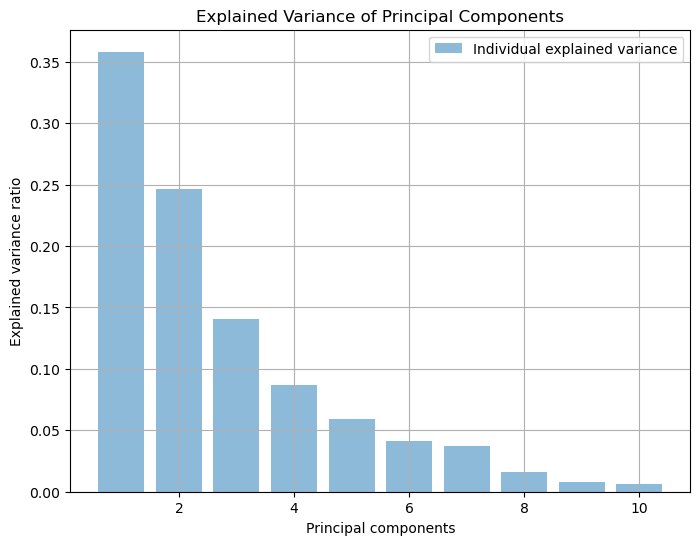

In [40]:
pca = PCA(n_components=10)
# Standardized data
X_standardized = StandardScaler().fit_transform(X)
X_pca = pca.fit_transform(X_standardized)
y = data['Direction'].values

# Calculate the explained variance
explained_variance = pca.explained_variance_ratio_

# Plotting explained variance
plt.figure(figsize=(8, 6))
plt.bar(range(1, len(explained_variance) + 1), explained_variance, alpha=0.5, align='center', label='Individual explained variance')
plt.xlabel('Principal components')
plt.ylabel('Explained variance ratio')
plt.title('Explained Variance of Principal Components')
plt.legend(loc='best')
plt.grid()
plt.show()

linear ,  0.1 :
Accuracy: 0.557632398753894


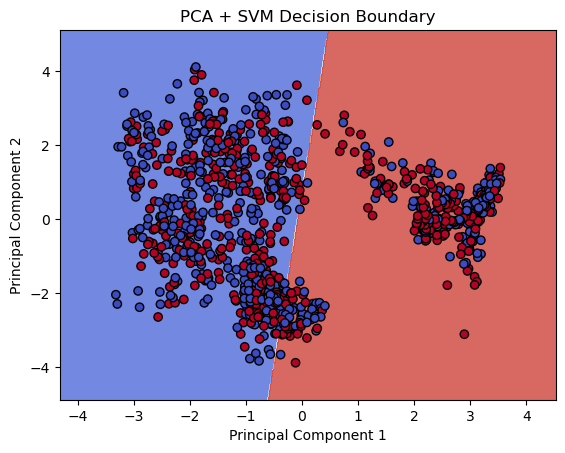

linear ,  1 :
Accuracy: 0.5638629283489096


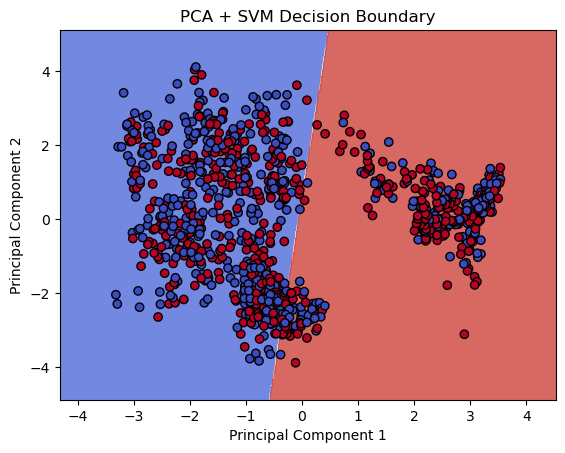

linear ,  10 :
Accuracy: 0.5638629283489096


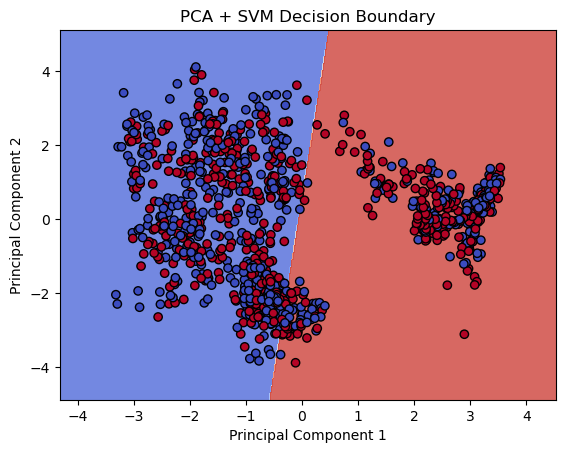

linear ,  100 :
Accuracy: 0.5638629283489096


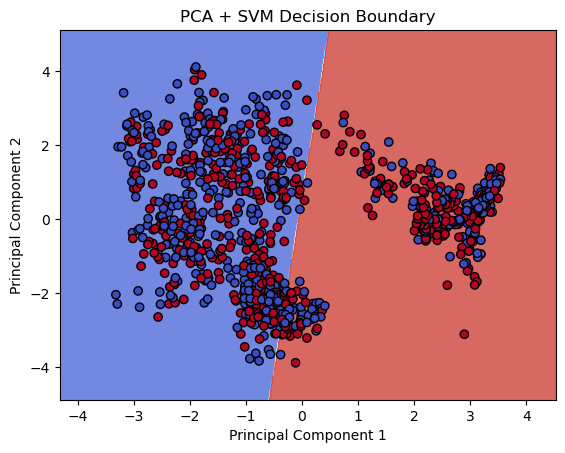

rbf ,  0.1 :
Accuracy: 0.5358255451713395


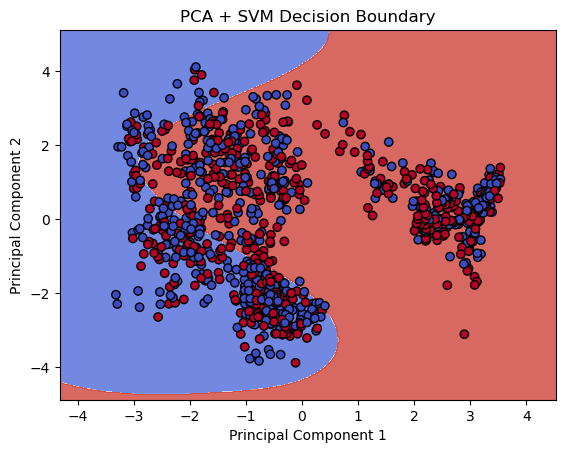

rbf ,  1 :
Accuracy: 0.5389408099688473


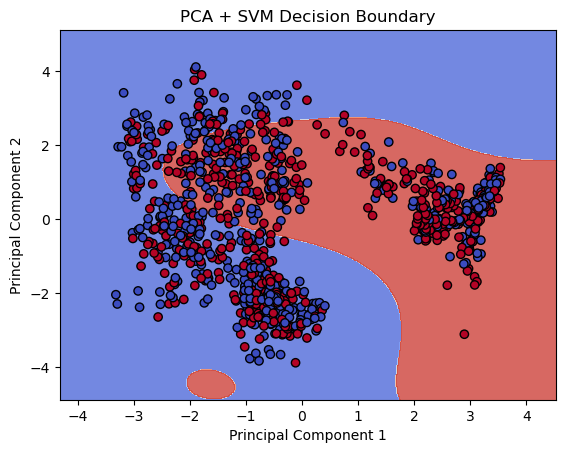

rbf ,  10 :
Accuracy: 0.5202492211838006


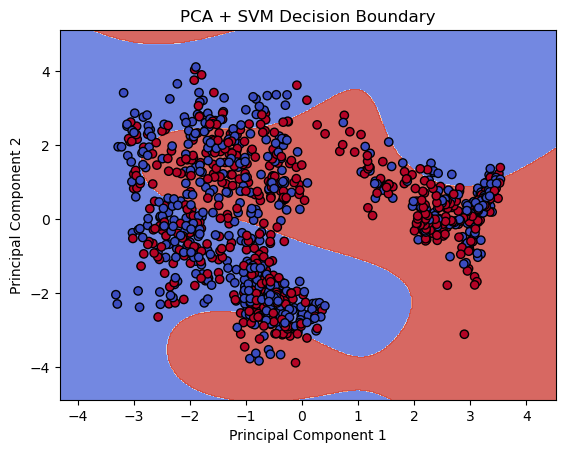

rbf ,  100 :
Accuracy: 0.5420560747663551


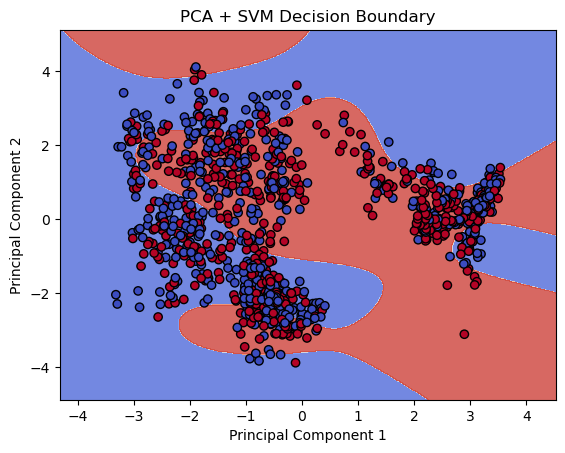

poly ,  0.1 :
Accuracy: 0.5295950155763239


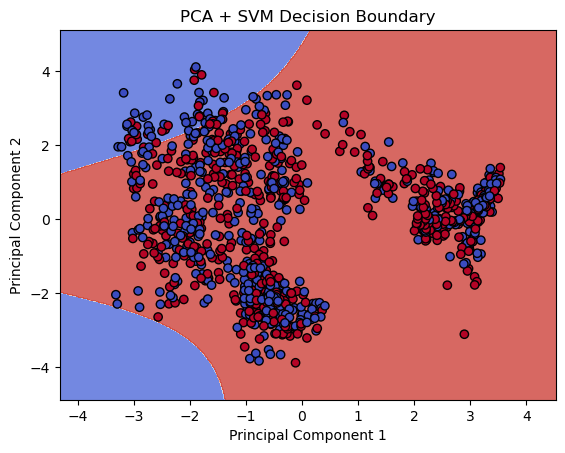

poly ,  1 :
Accuracy: 0.5233644859813084


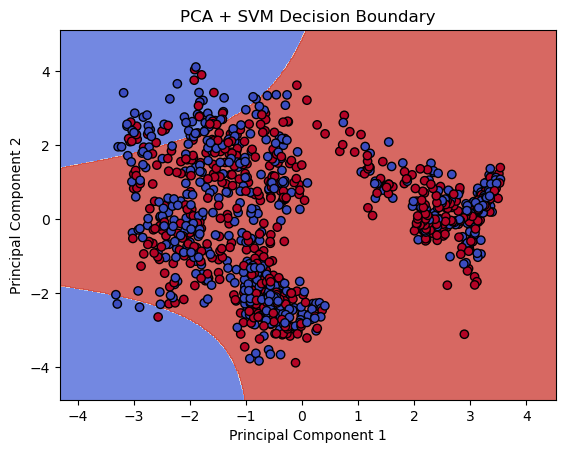

poly ,  10 :
Accuracy: 0.5233644859813084


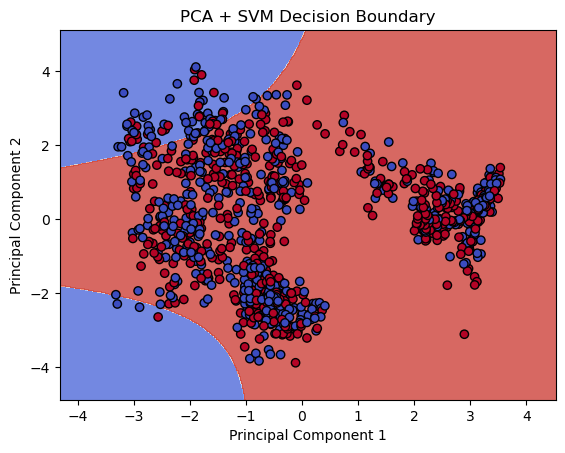

poly ,  100 :
Accuracy: 0.5233644859813084


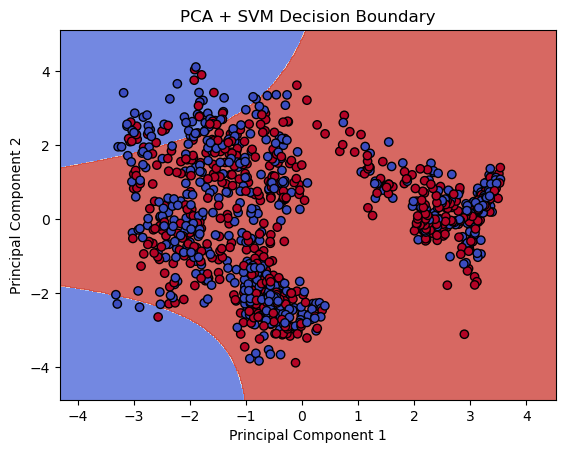

sigmoid ,  0.1 :
Accuracy: 0.5700934579439252


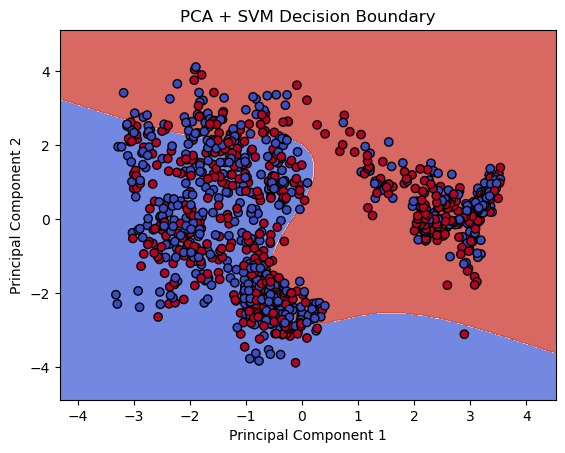

sigmoid ,  1 :
Accuracy: 0.5327102803738317


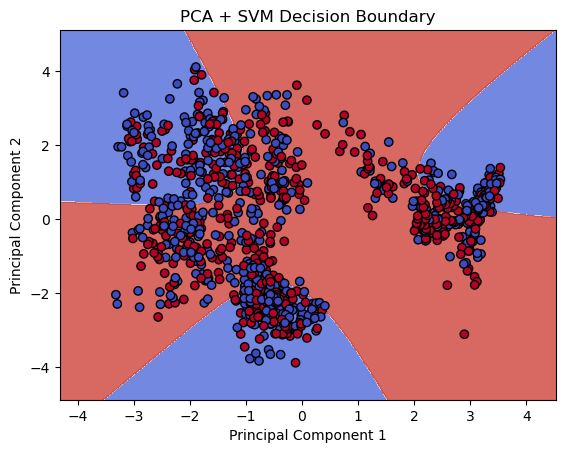

sigmoid ,  10 :
Accuracy: 0.5264797507788161


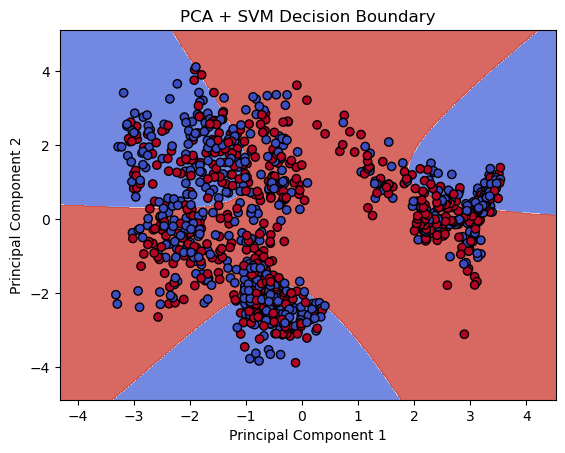

sigmoid ,  100 :
Accuracy: 0.5327102803738317


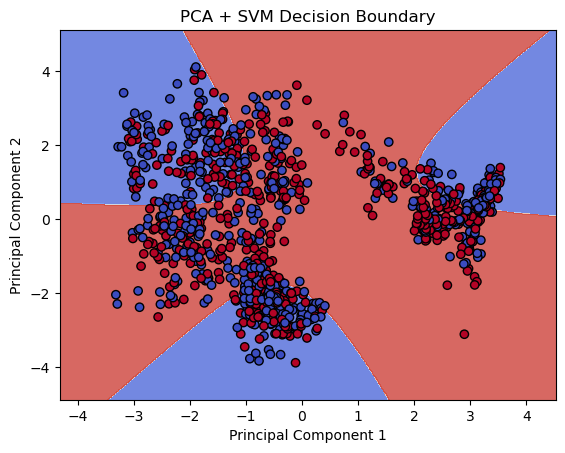

In [42]:
from sklearn.metrics import confusion_matrix

# Standardized data
X_standardized = StandardScaler().fit_transform(X)

# PCA downgraded to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)
y = data['Direction'].values

# Splitting the dataset after dimensionality reduction
X_train_pca, X_test_pca, y_train_pca, y_test_pca, _, return_test = train_test_split(X_pca, y, data['Return'].values, test_size=0.3, random_state=42)

for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
    for C in [0.1, 1, 10, 100]:
        svm_model_pca = SVC(kernel = kernel, C = C, random_state = 42)
        svm_model_pca.fit(X_train_pca, y_train_pca)
        
        y_pred_pca = svm_model_pca.predict(X_test_pca)
        accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
        
        print(kernel, ', ', C, ':')
        print(f"Accuracy: {accuracy_pca}")
        
        def plot_pca_svm_decision_boundary(X, y, model):
            h = .02  # Grid steps
            x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                 np.arange(y_min, y_max, h))
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.title('PCA + SVM Decision Boundary')
            plt.show()
        
        plot_pca_svm_decision_boundary(X_pca, y, svm_model_pca)

linear
Accuracy: 0.5638629283489096


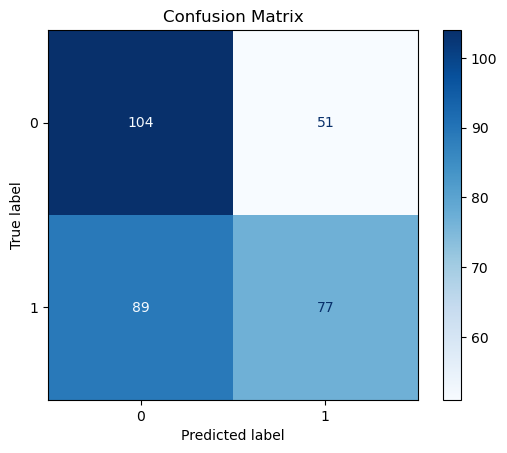

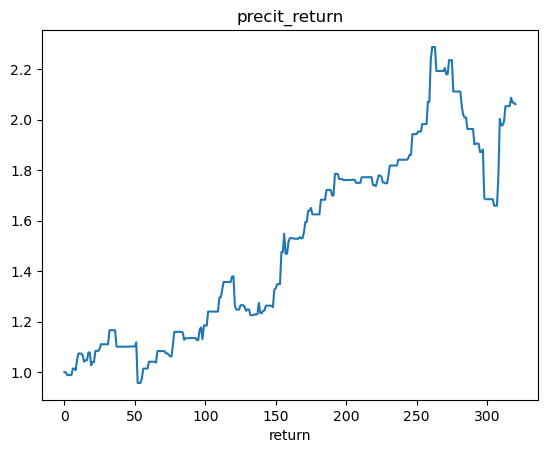

In [45]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)
y = data['Direction'].values

# Splitting the dataset after dimensionality reduction
X_train_pca, X_test_pca, y_train_pca, y_test_pca, _, return_test = train_test_split(X_pca, y, data['Return'].values, test_size=0.3, random_state=42)

for kernel,C in [('linear',1)]:
    svm_model_pca = SVC(kernel = kernel, C = C, random_state = 42)
    svm_model_pca.fit(X_train_pca, y_train_pca)
    y_pred_pca = svm_model_pca.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
    print(kernel)
    print(f"Accuracy: {accuracy_pca}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test_pca, y_pred_pca)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=data.target_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # plot predicted return
    plt.plot(range(len(y_pred_pca)), (1 + y_pred_pca * return_test).cumprod())
    plt.xlabel('time')
    plt.xlabel('return')
    plt.title('precit_return')
    plt.show()

### sentiments

In [46]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Read Bitcoin Historical Price Data
data = pd.read_csv('bitcoin_prices.csv', parse_dates=['Date'])
data = pd.merge(data, sentiment['sentiments_25'].reset_index(), left_on = 'Date', right_on = 'date', how = 'left')
data = data.set_index('Date')
data['Inflation'] = cpi_data['CPIAUCSL'].resample('D').ffill().reindex(data.index)
data['vw_crypto'] = value_weighted_index.reindex(data.index)
data['GPR'] = daily_gpr_index['GPRD'].reindex(data.index)
data['hash_rate'] = hash_data.reindex(data.index)
data['Close_mstr'] = mstr_data.rename(columns={'Close':'Close_mstr'})['Close_mstr'].reindex(data.index)
data = data.reset_index()

# Calculate the daily rate of return
data['Return'] = data['Close'].pct_change()
data['Return_mstr'] = data['Close_mstr'].pct_change()
data['Return_25'] = data['Return'].rolling(window=25, min_periods=25).sum()

# Marking up (1) and down (0)
data['Direction'] = (data['Return'] > 0).astype(int)

# shift and Remove missing values
data[['sentiments_25','Inflation','vw_crypto','GPR','hash_rate','Return_mstr','Close_mstr','Close','Return','Return_25']] = data[['sentiments_25','Inflation','vw_crypto','GPR','hash_rate','Return_mstr','Close_mstr','Close','Return','Return_25']].shift(1).fillna(method='ffill')
data.dropna(inplace=True)

# Features and labels
X = data[['sentiments_25','Inflation','vw_crypto','GPR','hash_rate','Return_mstr','Close_mstr','Close','Return','Return_25']].values
y = data['Direction'].values

linear ,  0.1 :
Accuracy: 0.5420560747663551


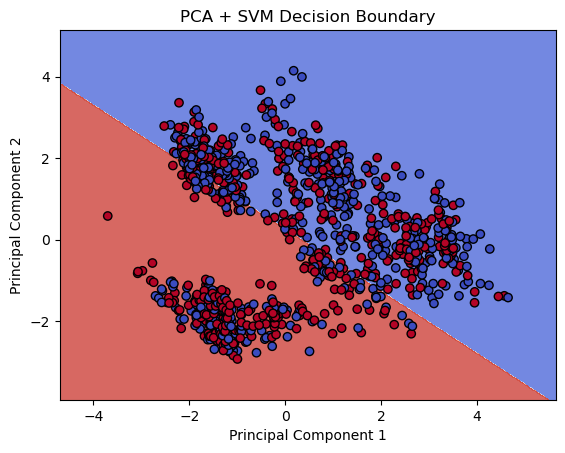

linear ,  1 :
Accuracy: 0.5514018691588785


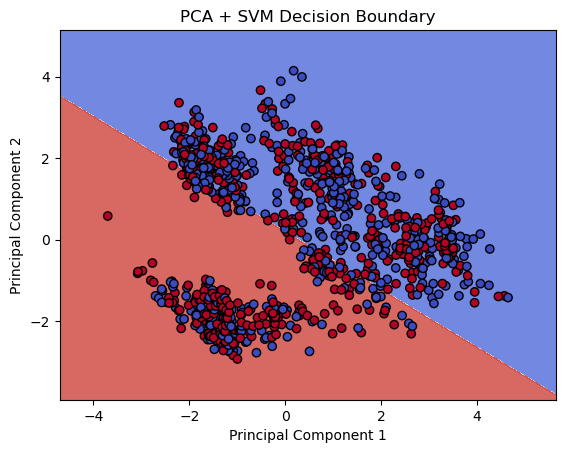

linear ,  10 :
Accuracy: 0.5514018691588785


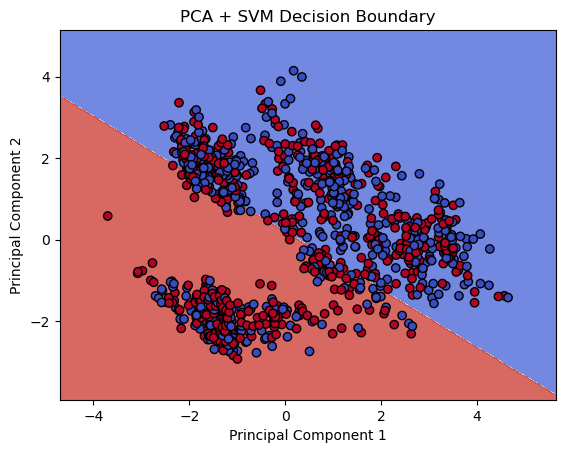

linear ,  100 :
Accuracy: 0.5514018691588785


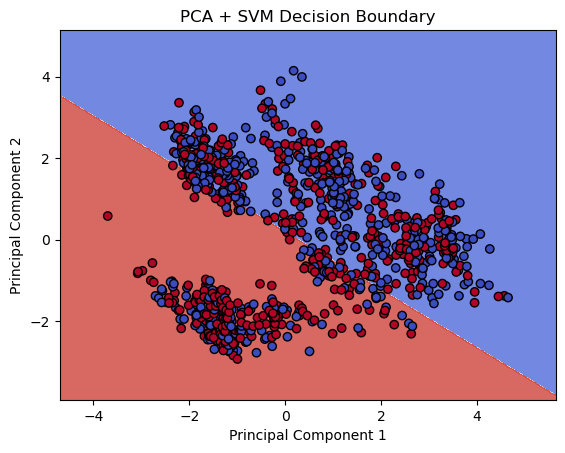

rbf ,  0.1 :
Accuracy: 0.5358255451713395


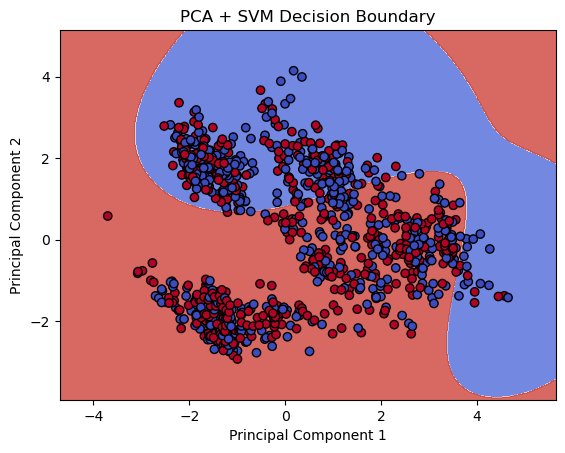

rbf ,  1 :
Accuracy: 0.5358255451713395


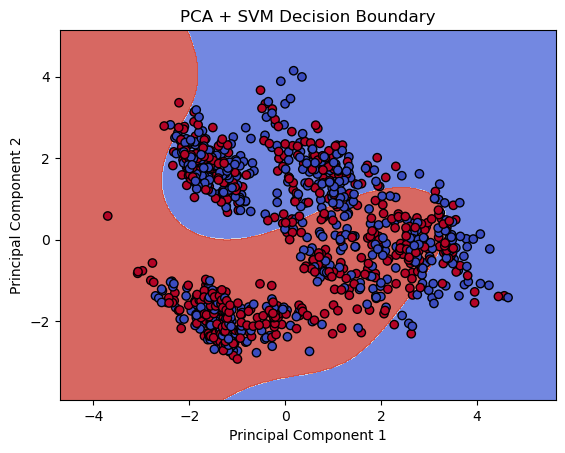

rbf ,  10 :
Accuracy: 0.5327102803738317


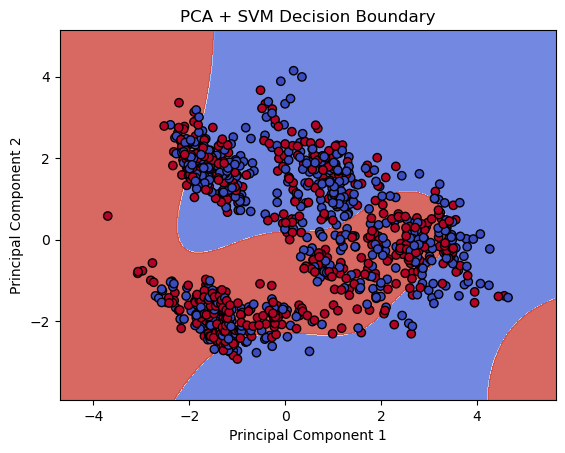

rbf ,  100 :
Accuracy: 0.5389408099688473


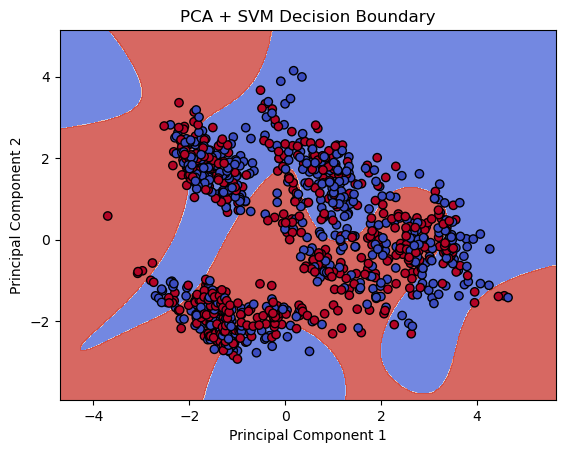

poly ,  0.1 :
Accuracy: 0.5264797507788161


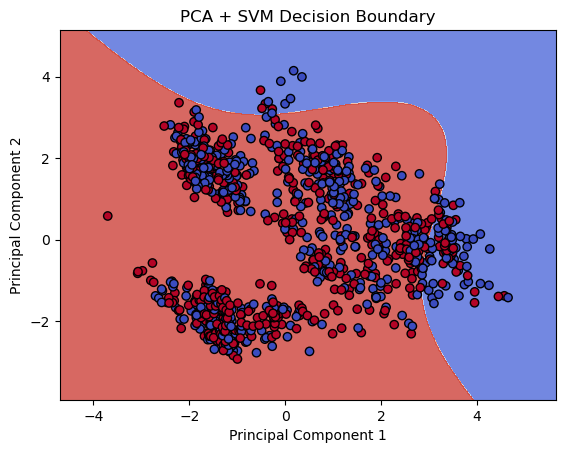

poly ,  1 :
Accuracy: 0.5264797507788161


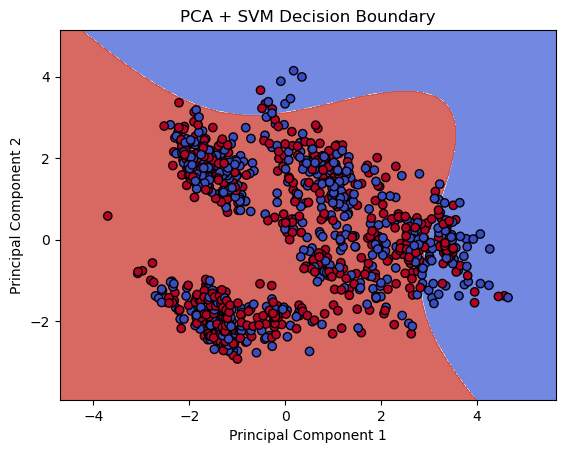

poly ,  10 :
Accuracy: 0.5264797507788161


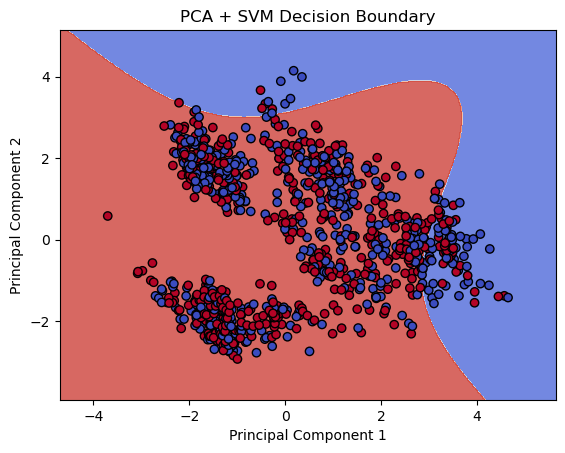

poly ,  100 :
Accuracy: 0.5264797507788161


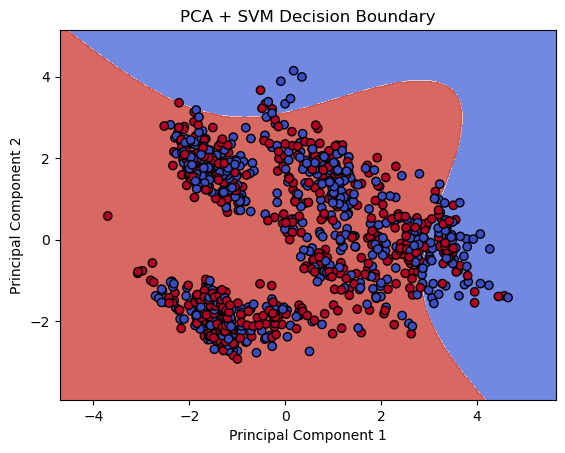

sigmoid ,  0.1 :
Accuracy: 0.5482866043613707


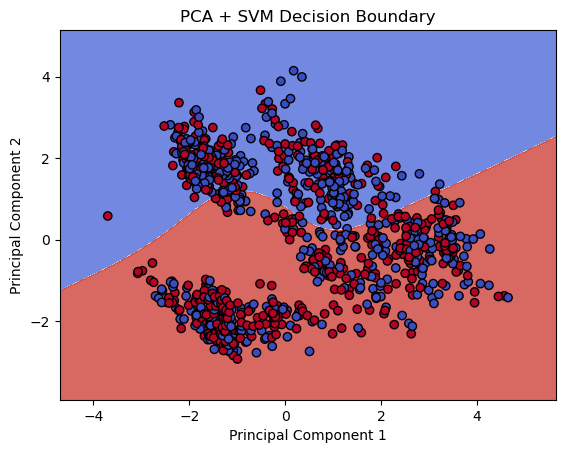

sigmoid ,  1 :
Accuracy: 0.4517133956386293


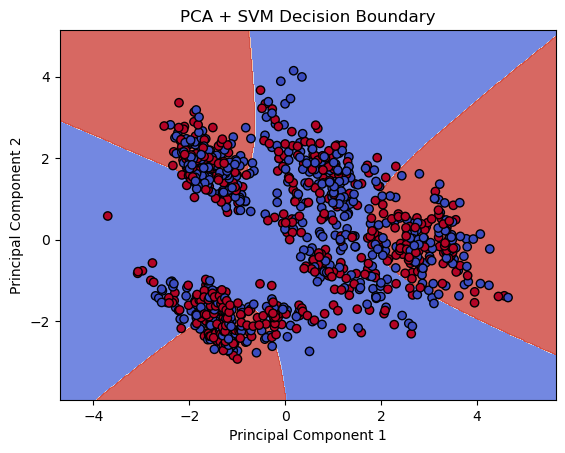

sigmoid ,  10 :
Accuracy: 0.45482866043613707


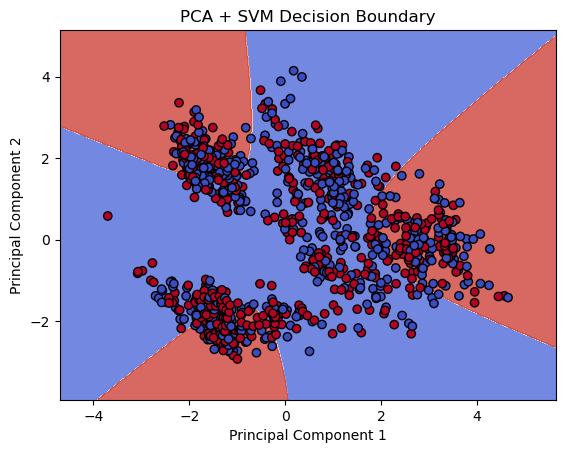

sigmoid ,  100 :
Accuracy: 0.5171339563862928


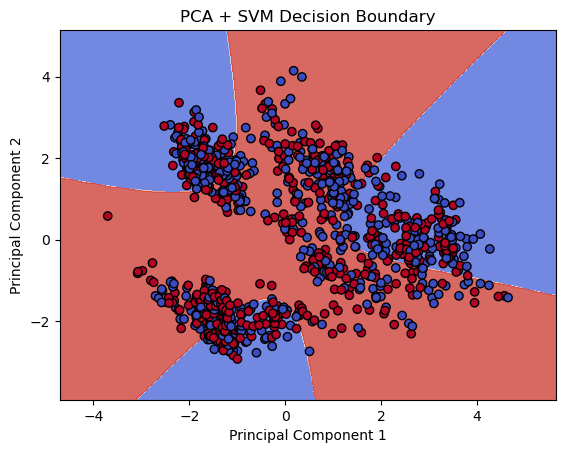

In [47]:
from sklearn.metrics import confusion_matrix

# Standardized data
X_standardized = StandardScaler().fit_transform(X)

# PCA downgraded to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)
y = data['Direction'].values

# Splitting the dataset after dimensionality reduction
X_train_pca, X_test_pca, y_train_pca, y_test_pca, _, return_test = train_test_split(X_pca, y, data['Return'].values, test_size=0.3, random_state=42)

for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
    for C in [0.1, 1, 10, 100]:
        svm_model_pca = SVC(kernel = kernel, C = C, random_state = 42)
        svm_model_pca.fit(X_train_pca, y_train_pca)
        
        y_pred_pca = svm_model_pca.predict(X_test_pca)
        accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
        
        print(kernel, ', ', C, ':')
        print(f"Accuracy: {accuracy_pca}")
        
        def plot_pca_svm_decision_boundary(X, y, model):
            h = .02  # Grid steps
            x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                 np.arange(y_min, y_max, h))
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.title('PCA + SVM Decision Boundary')
            plt.show()
        
        plot_pca_svm_decision_boundary(X_pca, y, svm_model_pca)

linear
Accuracy: 0.5514018691588785


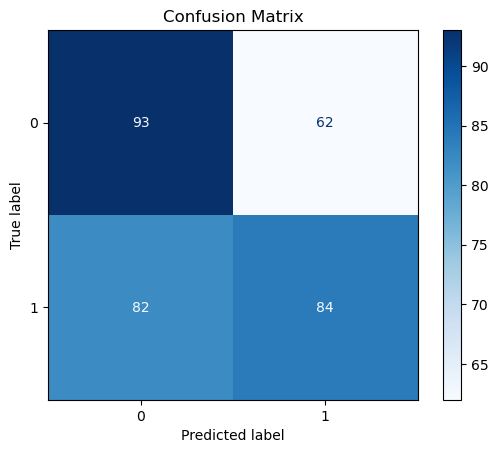

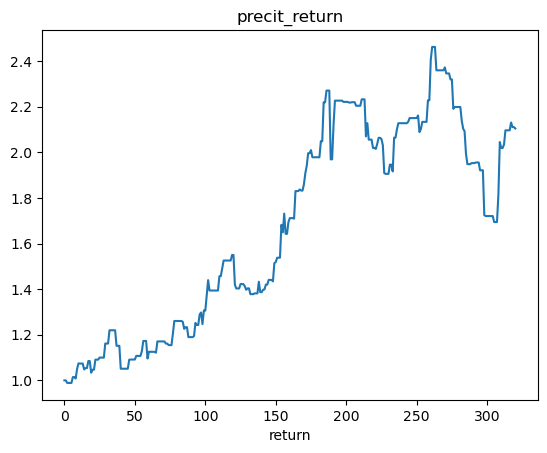

sigmoid
Accuracy: 0.5482866043613707


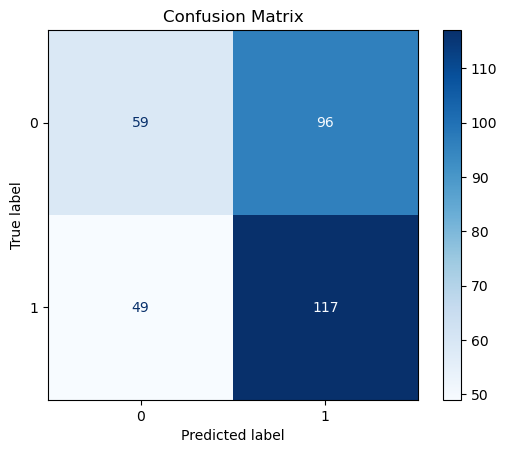

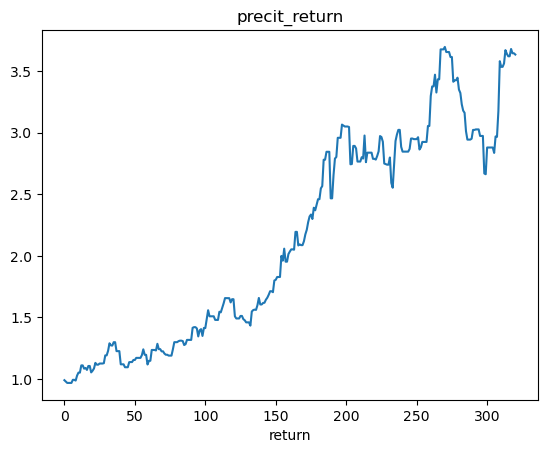

In [48]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)
y = data['Direction'].values

# Splitting the dataset after dimensionality reduction
X_train_pca, X_test_pca, y_train_pca, y_test_pca, _, return_test = train_test_split(X_pca, y, data['Return'].values, test_size=0.3, random_state=42)

for kernel,C in [('linear',1),('sigmoid', 0.1)]:
    svm_model_pca = SVC(kernel = kernel, C = C, random_state = 42)
    svm_model_pca.fit(X_train_pca, y_train_pca)
    y_pred_pca = svm_model_pca.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
    print(kernel)
    print(f"Accuracy: {accuracy_pca}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test_pca, y_pred_pca)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=data.target_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # plot predicted return
    plt.plot(range(len(y_pred_pca)), (1 + y_pred_pca * return_test).cumprod())
    plt.xlabel('time')
    plt.xlabel('return')
    plt.title('precit_return')
    plt.show()

### sentiment + harsh rate percent

In [49]:
import pandas as pd
from sklearn.preprocessing import StandardScaler
from sklearn.decomposition import PCA
from sklearn.svm import SVC, SVR
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import accuracy_score
from sklearn.metrics import mean_squared_error, r2_score
import matplotlib.pyplot as plt
import numpy as np

# Read Bitcoin Historical Price Data
data = pd.read_csv('bitcoin_prices.csv', parse_dates=['Date'])
data = pd.merge(data, sentiment['sentiments_25'].reset_index(), left_on = 'Date', right_on = 'date', how = 'left')
data = data.set_index('Date')
data['Inflation'] = cpi_data['CPIAUCSL'].resample('D').ffill().reindex(data.index)
data['vw_crypto'] = value_weighted_index.reindex(data.index)
data['GPR'] = daily_gpr_index['GPRD'].reindex(data.index)
data['hash_rate'] = merged_data['hash_rate_pct_change'].reindex(data.index)
data['Close_mstr'] = mstr_data.rename(columns={'Close':'Close_mstr'})['Close_mstr'].reindex(data.index)
data = data.reset_index()

# Calculate the daily rate of return
data['Return'] = data['Close'].pct_change()
data['Return_mstr'] = data['Close_mstr'].pct_change()
data['Return_25'] = data['Return'].rolling(window=25, min_periods=25).sum()

# Marking up (1) and down (0)
data['Direction'] = (data['Return'] > 0).astype(int)

# shift and Remove missing values
data[['sentiments_25','Inflation','vw_crypto','GPR','hash_rate','Return_mstr','Close_mstr','Close','Return','Return_25']] = data[['sentiments_25','Inflation','vw_crypto','GPR','hash_rate','Return_mstr','Close_mstr','Close','Return','Return_25']].shift(1).fillna(method='ffill')
data.dropna(inplace=True)

# Features and labels
X = data[['sentiments_25','Inflation','vw_crypto','GPR','hash_rate','Return_mstr','Close_mstr','Close','Return','Return_25']].values
y = data['Direction'].values

linear ,  0.1 :
Accuracy: 0.5295950155763239


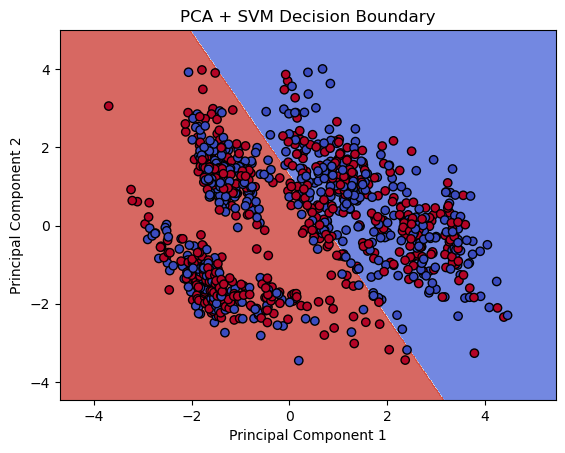

linear ,  1 :
Accuracy: 0.5295950155763239


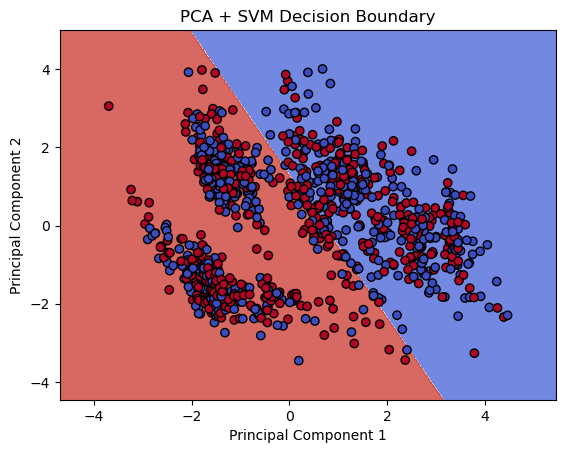

linear ,  10 :
Accuracy: 0.5295950155763239


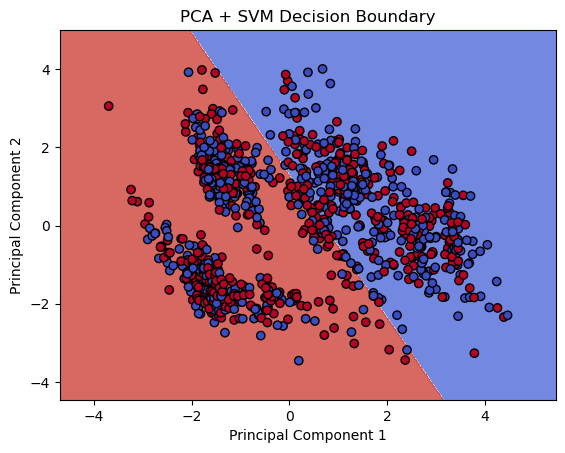

linear ,  100 :
Accuracy: 0.5295950155763239


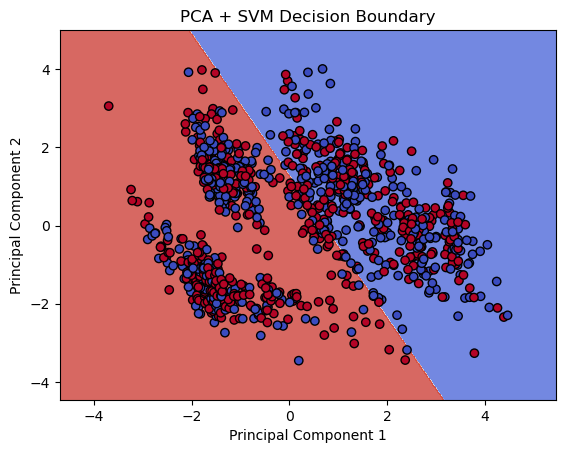

rbf ,  0.1 :
Accuracy: 0.5171339563862928


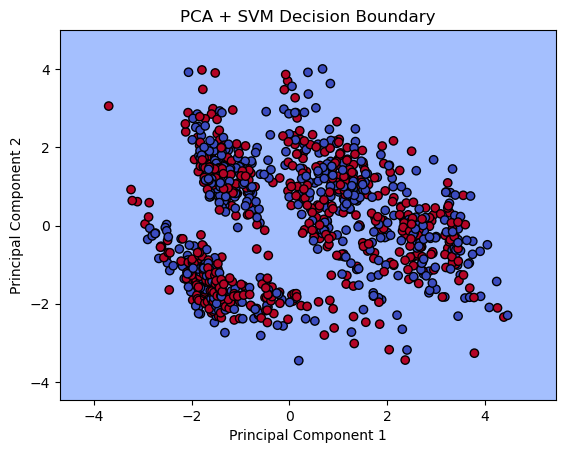

rbf ,  1 :
Accuracy: 0.5389408099688473


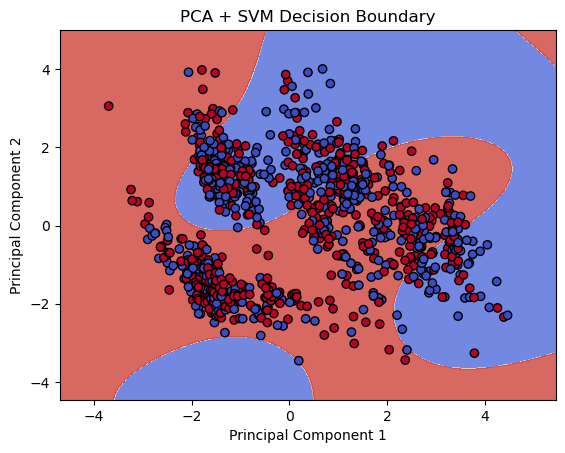

rbf ,  10 :
Accuracy: 0.5358255451713395


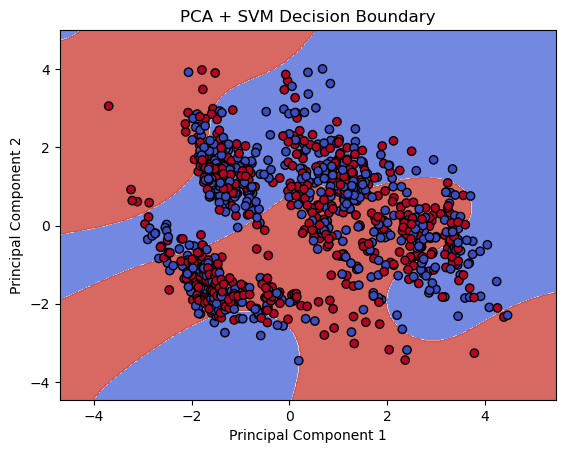

rbf ,  100 :
Accuracy: 0.5171339563862928


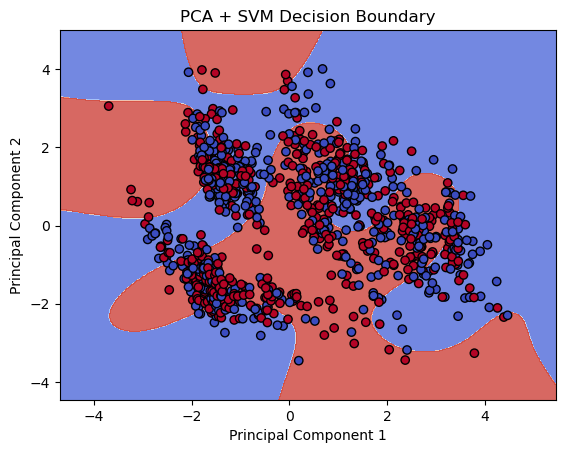

poly ,  0.1 :
Accuracy: 0.5233644859813084


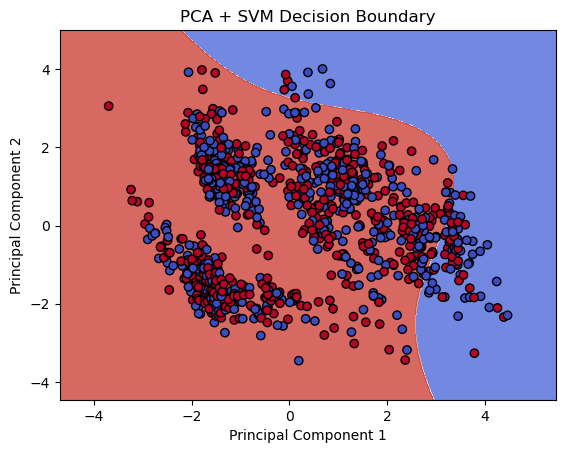

poly ,  1 :
Accuracy: 0.5264797507788161


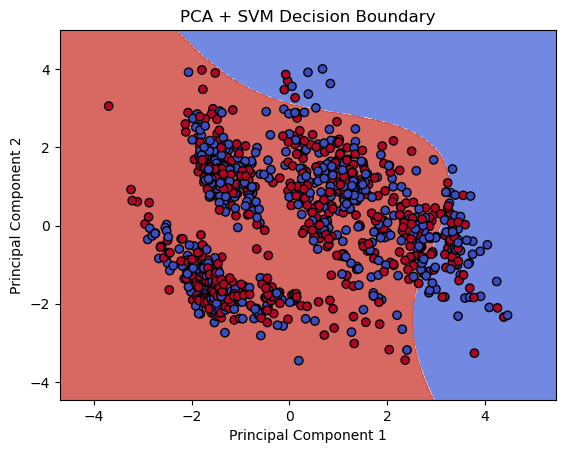

poly ,  10 :
Accuracy: 0.5264797507788161


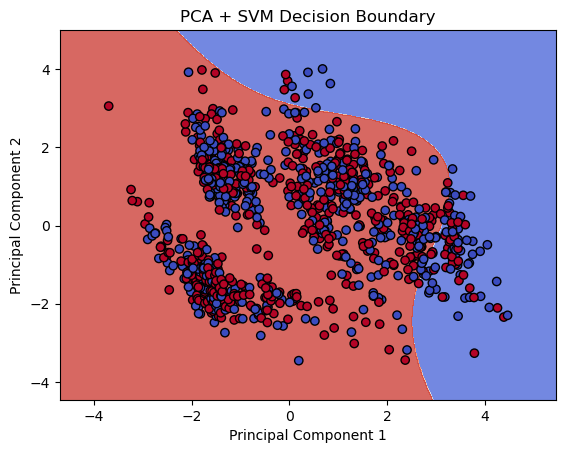

poly ,  100 :
Accuracy: 0.5264797507788161


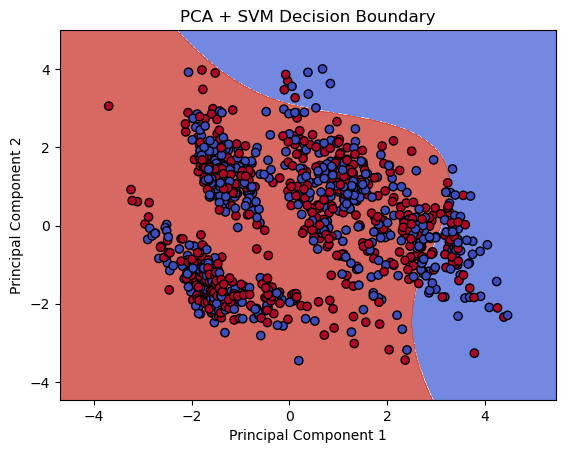

sigmoid ,  0.1 :
Accuracy: 0.5295950155763239


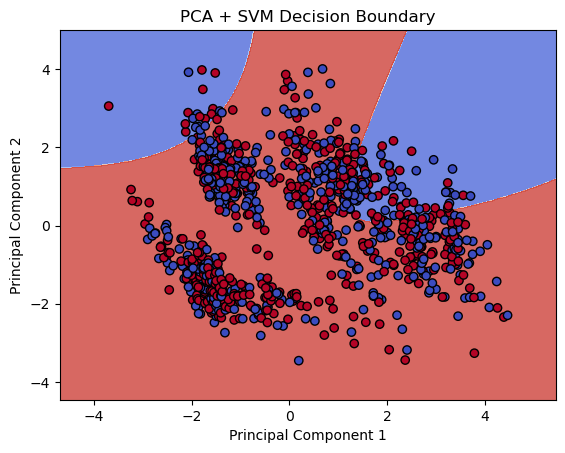

sigmoid ,  1 :
Accuracy: 0.48909657320872274


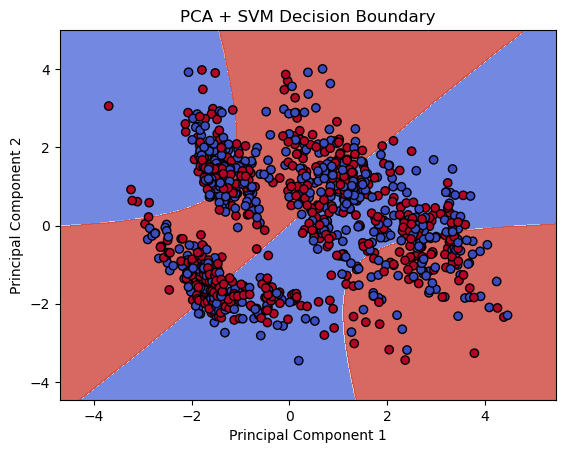

sigmoid ,  10 :
Accuracy: 0.48909657320872274


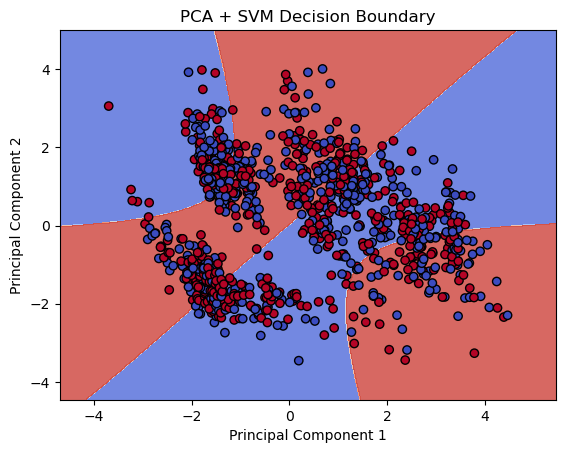

sigmoid ,  100 :
Accuracy: 0.49221183800623053


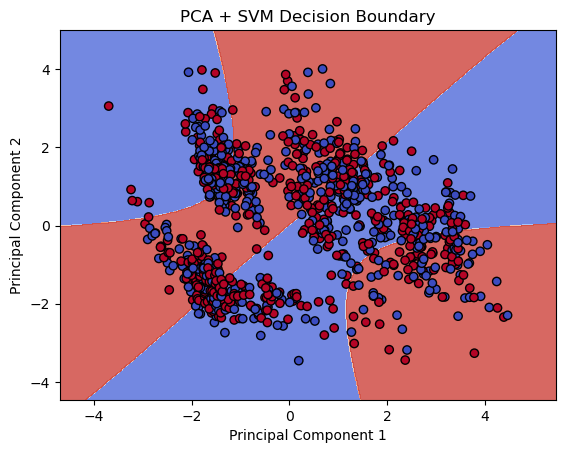

In [50]:
from sklearn.metrics import confusion_matrix

# Standardized data
X_standardized = StandardScaler().fit_transform(X)

# PCA downgraded to 2 dimensions
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)
y = data['Direction'].values

# Splitting the dataset after dimensionality reduction
X_train_pca, X_test_pca, y_train_pca, y_test_pca, _, return_test = train_test_split(X_pca, y, data['Return'].values, test_size=0.3, random_state=42)

for kernel in ['linear', 'rbf', 'poly', 'sigmoid']:
    for C in [0.1, 1, 10, 100]:
        svm_model_pca = SVC(kernel = kernel, C = C, random_state = 42)
        svm_model_pca.fit(X_train_pca, y_train_pca)
        
        y_pred_pca = svm_model_pca.predict(X_test_pca)
        accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
        
        print(kernel, ', ', C, ':')
        print(f"Accuracy: {accuracy_pca}")
        
        def plot_pca_svm_decision_boundary(X, y, model):
            h = .02  # Grid steps
            x_min, x_max = X[:, 0].min() - 1, X[:, 0].max() + 1
            y_min, y_max = X[:, 1].min() - 1, X[:, 1].max() + 1
            xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                                 np.arange(y_min, y_max, h))
            Z = model.predict(np.c_[xx.ravel(), yy.ravel()])
            Z = Z.reshape(xx.shape)
            plt.contourf(xx, yy, Z, cmap=plt.cm.coolwarm, alpha=0.8)
            plt.scatter(X[:, 0], X[:, 1], c=y, cmap=plt.cm.coolwarm, edgecolors='k')
            plt.xlabel('Principal Component 1')
            plt.ylabel('Principal Component 2')
            plt.title('PCA + SVM Decision Boundary')
            plt.show()
        
        plot_pca_svm_decision_boundary(X_pca, y, svm_model_pca)

linear
Accuracy: 0.5295950155763239


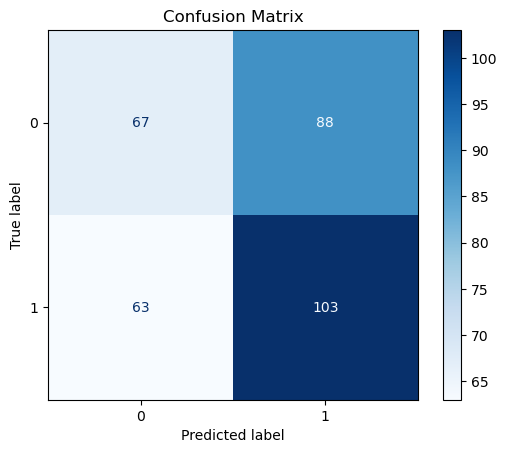

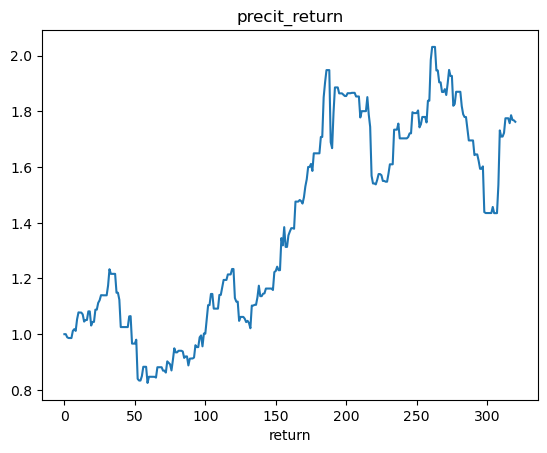

In [52]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_standardized)
y = data['Direction'].values

# Splitting the dataset after dimensionality reduction
X_train_pca, X_test_pca, y_train_pca, y_test_pca, _, return_test = train_test_split(X_pca, y, data['Return'].values, test_size=0.3, random_state=42)

for kernel,C in [('linear',1)]:
    svm_model_pca = SVC(kernel = kernel, C = C, random_state = 42)
    svm_model_pca.fit(X_train_pca, y_train_pca)
    y_pred_pca = svm_model_pca.predict(X_test_pca)
    accuracy_pca = accuracy_score(y_test_pca, y_pred_pca)
    print(kernel)
    print(f"Accuracy: {accuracy_pca}")
    
    # plot confusion matrix
    cm = confusion_matrix(y_test_pca, y_pred_pca)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)#, display_labels=data.target_names)
    disp.plot(cmap=plt.cm.Blues)
    plt.title('Confusion Matrix')
    plt.show()

    # plot predicted return
    plt.plot(range(len(y_pred_pca)), (1 + y_pred_pca * return_test).cumprod())
    plt.xlabel('time')
    plt.xlabel('return')
    plt.title('precit_return')
    plt.show()